# Use SurvivalEVAL for scikit-survival model

In this notebook we introduce the use of `ScikitSurvivalEvaluator` in the package to evaluate the performance for a scikit-survival model.
The first half of this notebook follows the procedure described in the Scikit-Survival [example](https://github.com/havakv/pycox/blob/master/examples/01_introduction.ipynb).


In the following, we will:
1. Load the German Breast Cancer Study Group 2 dataset;
2. Train the `CoxPH` model using 70% of the data;
3. Perform evaluation on the 30% testing set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import check_y_survival

from Evaluator import ScikitSurvivalEvaluator

In [ ]:
%matplotlib inline

Load and prepare data.

In [2]:
X, y = load_gbsg2()
X.loc[:, "tgrade"] = X.loc[:, "tgrade"].map(len).astype(int)
Xt = OneHotEncoder().fit_transform(X)

Splitting the data into training/testing set. Training set contains 70% of the data. Testing set contains 30%.

In [3]:
n = len(Xt)

tr_size = int(n*0.70)

Xt_train, Xt_test = Xt.iloc[:tr_size, :], Xt.iloc[tr_size:, :]
y_train, y_test = y[:tr_size], y[tr_size:]
train_event_indicators, train_event_times = check_y_survival(y_train)
test_event_indicators, test_event_times = check_y_survival(y_test)


Fit a CoxPH model.

In [4]:
est = CoxPHSurvivalAnalysis(ties="efron").fit(Xt_train, y_train)

Retrieve individual survival functions and get probability of remaining event free from 1 year to 5 years (=1825 days).

In [5]:
survs = est.predict_survival_function(Xt_test)

Build the evaluator. Training set information (`durations_train` and `events_train`) is optional if you don't need Brier score, integrated Brier score, and L1-margin loss.

In [6]:
eval = ScikitSurvivalEvaluator(survs, test_event_times, test_event_indicators, train_event_times, train_event_indicators)

Calculate the concordance index. `ties` argument indicates the way ties should be handled.
`predicted_time_method` argument indicates whether using median or mean survival time as the predicted time.

In [7]:
cindex, concordant_pairs, total_pairs = eval.concordance(ties="None", predicted_time_method="Median")
print("Concordance index is {}, meaning that the model can correctly order {} pairs among {} comparable pairs "
      "in the testing set.".format(cindex, concordant_pairs, total_pairs))

Concordance index is 0.6612887062831947, meaning that the model can correctly order 6599 pairs among 9979 comparable pairs in the testing set.


Calculate the Brier score at time 175.

In [8]:
bs = eval.brier_score(target_time=175)
print("Brier score at time 175 is {}.".format(bs))

Brier score at time 175 is 0.009235037097327975.


Calculate the integrated Brier score across all the time range. You can specify the number of points to integral.
If not specify, the default setting will use the censored time points obtained from testing set.

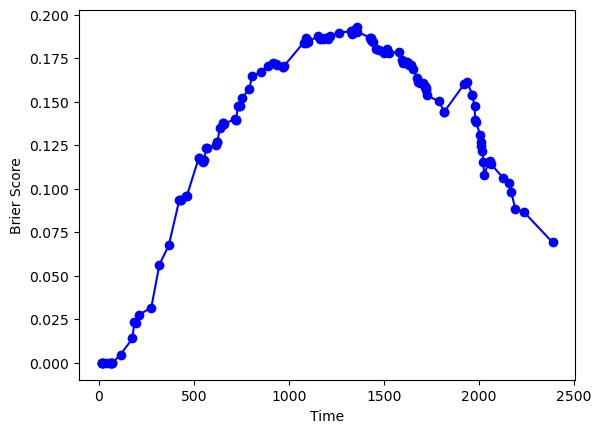

Integrated Brier score is 0.1282738154931309.


In [9]:
ibs = eval.integrated_brier_score(num_points=None, draw_figure=True)
print("Integrated Brier score is {}.".format(ibs))

Calculate the l1-margin loss using mean survival times obtain from the survival curves as the predicted survival times.
You can set `method` as 'Hinge' or 'Uncensored' for different l1 loss calculation.

In [11]:
l1 = eval.l1_loss(method='Margin', predicted_time_method="Median")
print("L1-margin loss is {}.".format(l1))

L1-margin loss is 1492.146010348475.


Run one calibration test at 50-percentile-time among all the instances in testing set.

In [10]:
t_time = round(np.percentile(test_event_times, 50))
p_value, ob, pre = eval.one_calibration(target_time=t_time, method="DN")
if p_value >= 0.05:
    print("The model is one-calibrated at time {}.".format(t_time))
else:
    print("The model is not one-calibrated at time {}.".format(t_time))

The model is one-calibrated at time 858.


Run distribution calibration test.

<Figure size 640x480 with 0 Axes>

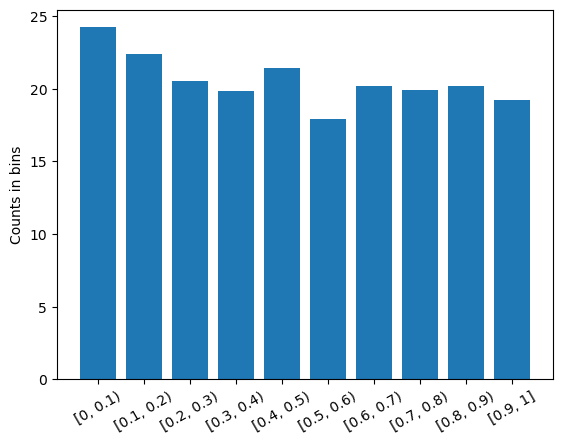

The model is d-calibrated!


In [12]:
p_value_2, bin_statistics = eval.d_calibration()
bins = ["[0, 0.1)", "[0.1, 0.2)", "[0.2, 0.3)", "[0.3, 0.4)", "[0.4, 0.5)", "[0.5, 0.6)", "[0.6, 0.7)", "[0.7, 0.8)",
        "[0.8, 0.9)", "[0.9, 1]"]
plt.clf()
fig, ax = plt.subplots()
ax.bar(bins, bin_statistics)
plt.setp(ax.get_xticklabels(), rotation=30)
plt.ylabel("Counts in bins")
plt.show()
if p_value_2 >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")